# Automatisch tellen van gistcellen

## Inleiding
In dit experiment gaan we de gistcellen detecteren en tellen in het microscopiebeeld dat jullie in het labo hebben bekeken en gefotografeerd. Hiervoor gebruiken we enkele standaard technieken uit de beeldverwerking. Doel is dat jullie deze begrijpen en kunnen toepassen op een soortgelijk beeld.

## Technische achtergrond (the gory details)
Wat jullie hier zien is een *jupyter notebook*, dat is een mengvorm tussen tekst, code en resultaten. Dit wordt zeer vaak gebruiks door data scientists tegenwoordig, omdat ze op deze manier interactief code kunnen aanpassen, hun resultaten zien en tegelijk een soort logboek bijhouden van hun experimenten.

De programmeertaam die we hierin gebruiken is *Python*. We veronderstellen op dit moment nog niet dat jullie Python kennen (dat komt nog wel), daarom hebben we alle code al voor jullie uitgeschreven. Zoals gezegd is alle code op deze pagina echte python code die live kan worden uitgevoerd. Bedoeling is dat jullie experimenteren met een aantal parameters, hun waarde veranderen en zien wat het effect daarvan is. Druk na elke wijziging op de 'play' knop bovenaan, of gebruik Shift-Enter.

Tenslotte: de bibliotheek die we gebruiken is scikit-image, een vaak gebruike; open-source bibliotheek met uitegreide functies voor digitale beeldverwerking.

Aan de slag!

In [1]:
# code block to initialise basic libraries: skimage, numpy and matplotlib
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib
# for creating a responsive plot
%matplotlib widget
import numpy as np

from skimage import data

## Microscopiebeeld
We laden een microscopiebeeld in dat jullie in het microscopielabo hebben onderzocht en laten het zien. Dit beeld is opgeslagen in Google Drive en voor iedereen toegangkelijk via het ingewikkeld ID dat hieronder staat. Een ander beeld heeft een ander ID. Als je zelf een beeld wil uitproberen, deel het dan via Google Drive, kopieer het ID en vul het hier in.

Het is een goede gewoonte om altijd je data te inspecteren voor je verder gaat, dat gaan we ook eerst doen.

image has size (4000, 3000) and looks like this:


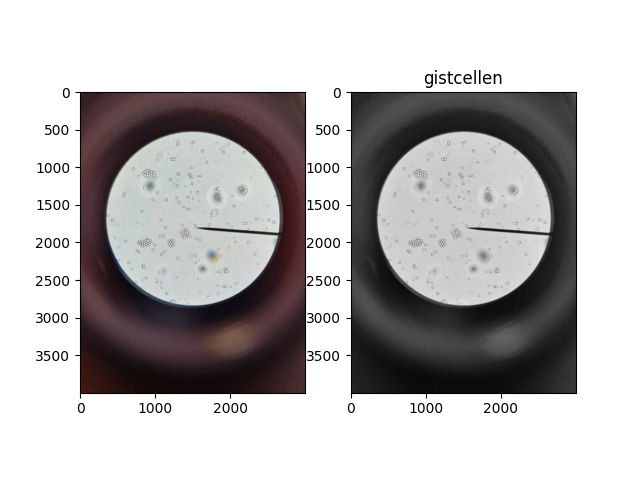

In [2]:
# code block to load and display images
# -------------------------------------
import imageio.v2 as iio

# load image stored in google drive and shared with everyone
dataID="1TwkzfaiCjqnGd8nCzjsVvWOPHLl5jxcG"
url="https://drive.google.com/uc?export=download&id="+dataID
    
# load image (taken from microscopy lab) and convert to greyvalues
name = 'gistcellen'
color_image = iio.imread(url)
#color_image = iio.imread("gistcellen_uit_microscopie_labo.jpg")
image = np.mean(color_image, axis=2)

# display images (original in color and in greyvalues)
print('image has size ' + str(image.shape) + ' and looks like this:')
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(color_image)
f.add_subplot(1,2, 2)
plt.imshow(image, cmap=plt.cm.gray)
plt.title(name)
plt.show()

In dit geval gaat het over een kleurenbeeld dat we hebben omgezet in een grijswaardenbeeld. Je kan de afmeting  zien boven het beeld. Elke pixelwaarde heeft een bereik van 0 tot 255 (8 bits of 1 byte), dat kan je interaktief onderzoeken door de muiscursor over het beeld te bewegen. In het kleine menu linksboven het beeld zie je ook een vierkant ikoontje dat je kan gebruiken om in te zoomen op een deel van het beeld. Dat kan je helpen om details beter te zien.

De cellen in dit beeld worden weergegeven door heldere cirkel/ellipsvormige objecten op een donkere achtergrond. Om beter te begrijpen welke grijswaarden er voorkomen in het beeld kan je interactief inzoomen.

## Inzoomen op een enkele gistcel
We gaan nu inzoomen op 1 gistcel. De coordinaten daarvan kan je een beetje inschatten aan de hand van het interaktief zoom tooltje hierboven. Coordinaten worden weergegeven als (rij, kolom). Een deel van een beeld beschrijf je als image (rijBegin:rijEinde, kolomBegin:kolomEinde).

Een andere manier om naar een grijswaardenbeeld te kijken is om het te beschouwen als een landschap waarin de grijswaarde de hoogte voorstelt. Dat doen we als volgt.

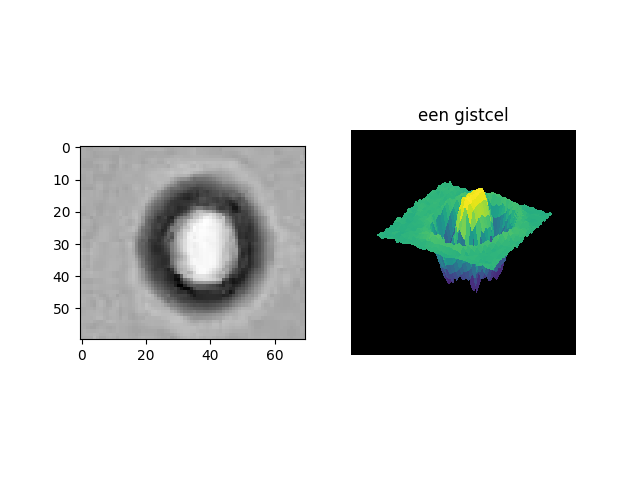

In [3]:
# code block show as landscape
# ------------------------------
from matplotlib import cm

# cut out part of the image containing 1 cell
cell = image[1770:1830, 1100:1170]

f2 = plt.figure()

# show greyvalue image of cell left
f2.add_subplot(1,2, 1)
plt.imshow(cell, cmap=plt.cm.gray)

# and landscape image of the same cell right
ax = f2.add_subplot(1,2, 2, projection='3d')

m, n=cell.shape
X, Y = np.meshgrid(np.arange(n), np.arange(m))

ax.plot_surface(X, Y, cell, cmap=cm.viridis, antialiased=False)
ax.axis("off")
ax.set_facecolor('black')
plt.title("een gistcel")
plt.show()

## Detectie van gistcellen door hun typisch voorkomen
Wat opvalt aan deze gistcellen is dat ze een heel specifiek uiterlijk hebben, een helder centrum omgeven door een dondere rand. Zowel het centrum als de rand tekenen scherp af ten opzichte van de middengrijze achtergrond.

VRAAG *Wat zijn typische grijswaarden van een celkern, de celrand, en de achtergrond?*

Schrijf je antwoord hier op: celkern: *waarde*, celrand: *waarde*, achtergrond: *waarde*

OPDRACHT *Kies eens een andere gistcel uit het beeld (pas hiervoor de coordinaten aan) en onderzoek of die cel er ook zo uitziet.*

# Template matching voor gistcellen
We gaan proberen of we alle cellen kunnen detecteren door ze te vergelijken met de afbeelding van een enkele cel. Die techniek noemen we *template matching*. We gebruiken het beeld van de enkele cel (opgeslagen in het beeld met naam 'cell') als een sjabloon of template waarmee we op zoek gaan naar die plaatsen in het microscopiebeeld (met naam 'image') die erop lijken.

Daartoe berekenen we de correlatie tussen elke positie in het beeld 'image' met het beeld van de ene cel 'cell'. Hoe dat precies gebeurt is niet zo relevant, wel belangrijk is het om te weten dat de correlatie een waarde 1 heeft bij een perfecte match (als de omgeving in 'image' perfect overeenkomt met het template 'cell'), -1 bij een perfect tegengestelde match waarbij de grijswaarden elkaars tegengestelde zijn, en tussenliggende waarden voor andere posities.

VRAAG *Verwachten jullie dat de waarde 1 voorkomt in het beeld?*

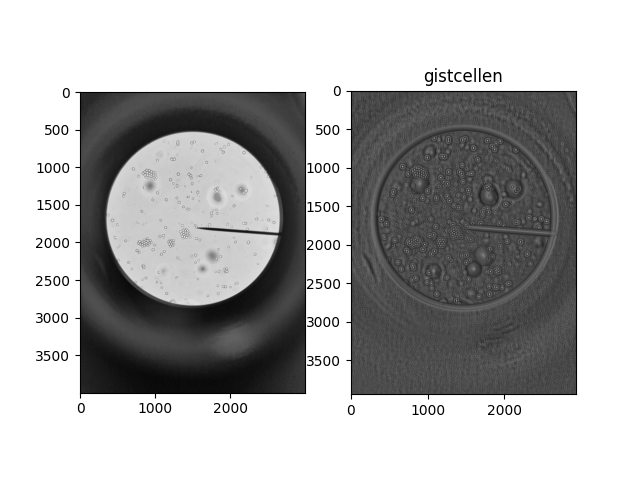

In [4]:
from skimage.feature import match_template

# calculate template matching from 'cell' to entire image
result = match_template(image, cell)

f3 = plt.figure()
f3.add_subplot(1,2, 1)
plt.imshow(image, cmap=plt.cm.gray)
f3.add_subplot(1,2, 2)
plt.imshow(result, cmap=plt.cm.gray)
plt.title(name)
plt.show()

Onderzoek de waarden in het gefilterde beeld rechts, waarop de template matching is toegepast. Vergelijk de plaatsen met gistcellen in het beeld links met de waarden in het beeld rechts. 

VRAAG *Welke waarde hebben de centra van de gistcellen in het gefilterde beeld rechts typisch?*

OPDRACHT *Zoek een drempelwaarde waarboven we de gistcellen kunnen detecteren en vul die hieronder in bij threshold_value.*

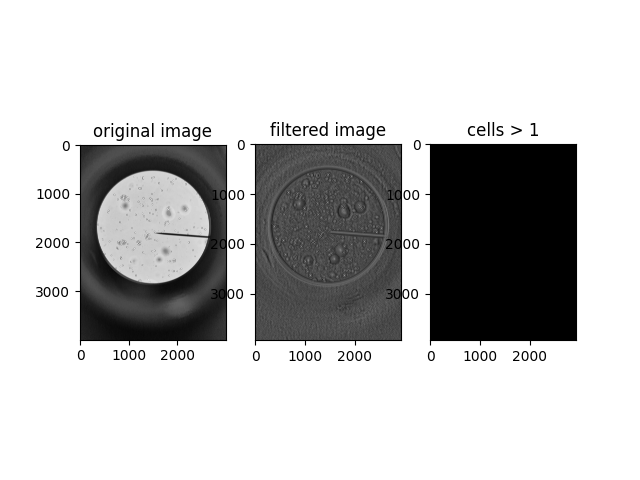

In [7]:
# code block to show thresholded image
# ------------------------------------
threshold_value = 1

thresholded_result  = result > threshold_value

# show original image, filtered image and thresholded result side-by-side
f3 = plt.figure()
f3.add_subplot(1,3, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('original image')
f3.add_subplot(1,3, 2)
plt.imshow(result, cmap=plt.cm.gray)
plt.title('filtered image')
f3.add_subplot(1,3, 3)
plt.imshow(result > threshold_value, cmap=plt.cm.gray)
plt.title('cells > ' + str(threshold_value))
plt.show()

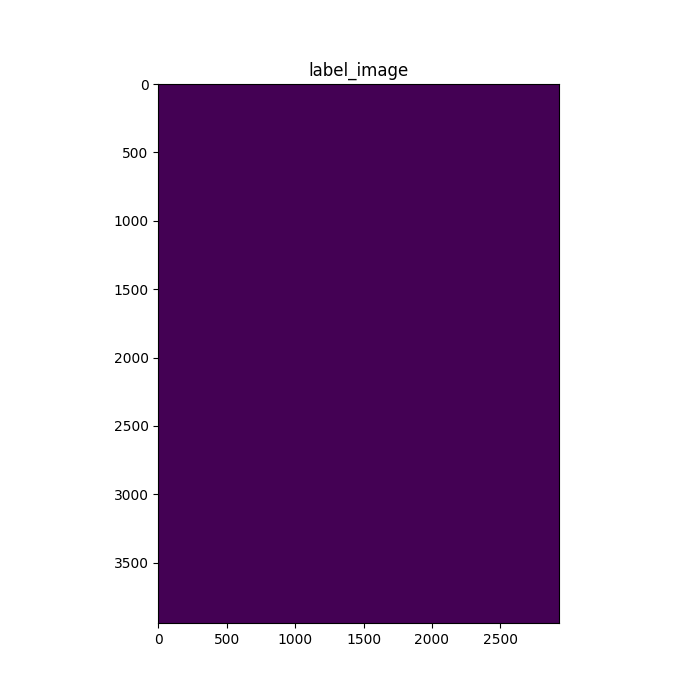

Maximum label value is 0


In [8]:
# code block to label all the blobs and count them
# ---------------------------------------------------------
from skimage.measure import label, regionprops

label_image = label(thresholded_result)
plt.figure(figsize=(7,7))
plt.imshow(label_image)
plt.title('label_image')
plt.show()
print('Maximum label value is '+ str(label_image.max()))

VRAAG *Hoeveel gistcellen hebben jullie gedetecteerd? Hoe weet je dat dat aantal klopt?*

OPDRACHT *Noteer alle parameters in dit algoritme die een invloed hebben op het eindresultaat.*

In de volgende stap gaan jullie zelf een probleem oplossen door met deze parameters te experimenteren.